In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/SemEval2023/SemEval2022-Task10/private_space

/content/gdrive/.shortcut-targets-by-id/1lC-ZKLaCDQyfLcof2Ak7FDa6IvTt318A/SemEval2023/SemEval2022-Task10/private_space


In [18]:
import pandas as pd

data = pd.read_csv("Data/starting_ki/train_all_tasks.csv")
data = data[data["label_category"]!="none"]

In [19]:
generated_data = pd.read_csv("../GeneratedTexts/task_c_generated_text.csv")

In [20]:
generated_data = generated_data[generated_data["predict"]!="not sexist"]

In [27]:
def remove_star(text):
  return text[2:].strip()

generated_data["text"] = generated_data["text"].apply(remove_star)

In [28]:
generated_data.columns = ["text", "label_vector", "predict"]

In [32]:
data = pd.concat([data, generated_data])

In [33]:
import json

with open('../Results/TaskC/lexicon_pmi.json') as fin:
    lexicon_pmi = json.load(fin)

with open('../Results/TaskC/lexicon_shapley.json') as fin:
    lexicon_shapley = json.load(fin)

with open('../Results/TaskC/lexicon_shapley_augmented_v2_shap.json') as fin:
    lexicon_shapley_augmented_v2_shap = json.load(fin)

with open('../Results/TaskC/lexicon_shapley_augmented_v3_gptj.json') as fin:
    lexicon_shapley_augmented_v3_gptj = json.load(fin)

with open('../Results/TaskC/lexicon_shapley_augmented_v4_tweetbert.json') as fin:
    lexicon_shapley_augmented_v4_tweetbert = json.load(fin)

In [35]:
task = "1c"

In [36]:
if not task.endswith("a"):
  data = data[data["label_category"]!="none"]

In [37]:
if task.endswith("a"):
  label_column = "label_sexist"
elif task.endswith("b"):
  label_column = "label_category"
elif task.endswith("c"):
  label_column = "label_vector"


label_column

'label_vector'

In [38]:
len(data)

7613

In [39]:
data[["text", label_column]].groupby(label_column).count()

,text
label_vector,
1.1 threats of harm,424
1.2 incitement and encouragement of harm,613
2.1 descriptive attacks,1124
2.2 aggressive and emotive attacks,1080
2.3 dehumanising attacks & overt sexual objectification,592
"3.1 casual use of gendered slurs, profanities, and insults",1108
3.2 immutable gender differences and gender stereotypes,859
3.3 backhanded gendered compliments,400
3.4 condescending explanations or unwelcome advice,276


In [40]:
# label_values = data[label_column].unique()
# label_values
if label_column == "label_sexist":
  label_values = [
      'sexist',
      'not sexist',
  ]

  label_map = {
      0: 'not sexist',
      1: 'sexist', 
      'not sexist':0,
      'sexist':1,
  }
elif label_column == "label_category":
  label_values = [
      '1. threats, plans to harm and incitement',
      '2. derogation',
      '3. animosity',
      '4. prejudiced discussions',
  ]

  label_map = {
      0: '1. threats, plans to harm and incitement',
      1: '2. derogation', 
      2: '3. animosity', 
      3: '4. prejudiced discussions',
      '1. threats, plans to harm and incitement':0,
      '2. derogation':1,
      '3. animosity':2,
      '4. prejudiced discussions':3,
  }
elif label_column == "label_vector":
  label_values = [
      '1.1 threats of harm',
      '1.2 incitement and encouragement of harm',
      '2.1 descriptive attacks',
      '2.2 aggressive and emotive attacks',
      '2.3 dehumanising attacks & overt sexual objectification',
      '3.1 casual use of gendered slurs, profanities, and insults',
      '3.2 immutable gender differences and gender stereotypes',
      '3.3 backhanded gendered compliments',
      '3.4 condescending explanations or unwelcome advice',
      '4.1 supporting mistreatment of individual women',
      '4.2 supporting systemic discrimination against women as a group',
  ]

  label_map = {
      0: '1.1 threats of harm',
      1: '1.2 incitement and encouragement of harm',
      2: '2.1 descriptive attacks',
      3: '2.2 aggressive and emotive attacks',
      4: '2.3 dehumanising attacks & overt sexual objectification',
      5: '3.1 casual use of gendered slurs, profanities, and insults',
      6: '3.2 immutable gender differences and gender stereotypes',
      7: '3.3 backhanded gendered compliments',
      8: '3.4 condescending explanations or unwelcome advice',
      9: '4.1 supporting mistreatment of individual women',
      10: '4.2 supporting systemic discrimination against women as a group',
      '1.1 threats of harm': 0,
      '1.2 incitement and encouragement of harm': 1,
      '2.1 descriptive attacks': 2,
      '2.2 aggressive and emotive attacks': 3,
      '2.3 dehumanising attacks & overt sexual objectification': 4,
      '3.1 casual use of gendered slurs, profanities, and insults': 5,
      '3.2 immutable gender differences and gender stereotypes': 6,
      '3.3 backhanded gendered compliments': 7,
      '3.4 condescending explanations or unwelcome advice': 8,
      '4.1 supporting mistreatment of individual women': 9,
      '4.2 supporting systemic discrimination against women as a group': 10,
  }
else:
  raise Exception("Unknown label column")

In [41]:
texts = data['text'].values

def label_to_number(label_map, label):
  return label_map[label]

labels = [label_to_number(label_map, d) for d in data[label_column].values]

In [42]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

1
154


In [43]:
sum(labels)

35059

# Prepare Data

In [44]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.6 MB/s eta 0:00:00


In [45]:
import transformers

In [46]:
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original Text:  just the inside of your wallet: cash, bank cards, credit cards, debit cards. That is the inside that matters to femoids. 

Tokenized Text:  ['just', 'the', 'inside', 'of', 'your', 'wallet', ':', 'cash', ',', 'bank', 'cards', ',', 'credit', 'cards', ',', 'de', '##bit', 'cards', '.', 'that', 'is', 'the', 'inside', 'that', 'matters', 'to', 'fe', '##mo', '##ids', '.'] 

Token IDs:  [2074, 1996, 2503, 1997, 2115, 15882, 1024, 5356, 1010, 2924, 5329, 1010, 4923, 5329, 1010, 2139, 16313, 5329, 1012, 2008, 2003, 1996, 2503, 2008, 5609, 2000, 10768, 5302, 9821, 1012]


In [47]:
!pip3 install -q nltk emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [48]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


nltktokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = nltktokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [49]:
normalizeTweet("DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier 😢")


'DHEC confirms HTTPURL ... via @USER :crying_face:'

In [50]:
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]

In [51]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))


100
100


In [52]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

In [53]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [56]:
from nltk.tokenize import  word_tokenize

# lexicons = lexicon_shapley
lexicons = lexicon_shapley_augmented_v2_shap

lexcon_emb = []
for text in texts:
  words = word_tokenize(text)

  embs = []
  for w in words:
    e = []
    for label in lexicons:
      if w in lexicons[label]:
        e.append(1.0)
      else:
        e.append(0.0)
    embs.append(e)

  while len(embs) < 100:
    embs.append([0 for l in lexicons])
  
  if len(embs) > 100:
    embs = embs[0:100]
  lexcon_emb.append(embs)


In [57]:
import torch
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y, train_m, test_val_m, train_l, test_val_l = train_test_split(text_ids, labels, att_masks, lexcon_emb, random_state=42, test_size=0.2)
test_x, val_x, test_y, val_y, test_m, val_m, test_l, val_l = train_test_split(test_val_x, test_val_y, test_val_m, test_val_l, random_state=42, test_size=0.5)


## Convert to tensor
train_x = torch.tensor(train_x);
test_x = torch.tensor(test_x);
val_x = torch.tensor(val_x);

train_y = torch.tensor(train_y);
test_y = torch.tensor(test_y);
val_y = torch.tensor(val_y);

train_m = torch.tensor(train_m);
test_m = torch.tensor(test_m);
val_m = torch.tensor(val_m);

train_l = torch.tensor(train_l);
test_l = torch.tensor(test_l);
val_l = torch.tensor(val_l);

In [58]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y, train_l)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y, val_l)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Load Model

In [59]:
from transformers import BertForSequenceClassification
from transformers import BertPreTrainedModel, BertModel
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.modeling_outputs import SequenceClassifierOutput


class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(in_features=config.hidden_size+config.num_labels, out_features=config.num_labels)
        self.lstm = nn.LSTM(input_size=config.num_labels, hidden_size=config.num_labels, num_layers=1, batch_first=True)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        lexicon_emb: Optional[torch.Tensor] = None
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:

        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)

        lstm_output, (ht, ct) = self.lstm(lexicon_emb)
        ht = torch.squeeze(ht, dim=0)
        
        concated_ouput = torch.cat((pooled_output, ht), 1)
        
        logits = self.classifier(concated_ouput)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [60]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoTokenizer

num_labels = len(set(labels))

model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, output_attentions=False, output_hidden_states=False)
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, output_attentions=False, output_hidden_states=False)
# model = BertForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=num_labels, output_attentions=False, output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing CustomBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing CustomBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomBertForSequenceClassification were not initialized from

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(device)

cuda


In [62]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Number of trainable parameters:', count_parameters(model), '\n', model)


## Fine-tune

In [63]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [64]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 10
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [65]:
import time
import numpy as np
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [66]:
from tqdm.notebook import tqdm
import os

train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)
tmp_out_dir = f'./Models/_tmp_x'

if num_mb_val == 0:
    num_mb_val = 1

best_loss = None
add_lexicon = True

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y, mb_l) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        mb_l = mb_l.to(device)
        
        if add_lexicon:
          outputs = model(mb_x, attention_mask=mb_m, labels=mb_y, lexicon_emb=mb_l)
        else:
          outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y, mb_l) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
            mb_l = mb_l.to(device)
        
            if add_lexicon:
              outputs = model(mb_x, attention_mask=mb_m, labels=mb_y, lexicon_emb=mb_l)
            else:
              outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val

        if best_loss is None or best_loss >= val_loss:
            
            if not os.path.exists(tmp_out_dir):
                os.makedirs(tmp_out_dir)
                
            model.save_pretrained(tmp_out_dir)
            # tokenizer.save_pretrained(tmp_out_dir)

            best_loss = val_loss

        print("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')



  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 1: 2.291745


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 1: 2.195661
Time: 1m 54s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 2: 2.132584


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 2: 2.117454
Time: 1m 48s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 3: 2.019211


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 3: 2.060808
Time: 1m 47s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 4: 1.904566


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 4: 2.042506
Time: 1m 47s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 5: 1.797951


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 5: 2.054931
Time: 1m 46s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 6: 1.688120


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 6: 2.042590
Time: 1m 46s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 7: 1.605339


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 7: 2.053906
Time: 1m 46s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 8: 1.534158


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 8: 2.072319
Time: 1m 46s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 9: 1.476500


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 9: 2.073568
Time: 1m 46s


  0%|          | 0/191 [00:00<?, ?it/s]


Train loss after itaration 10: 1.441595


  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss after itaration 10: 2.079506
Time: 1m 46s


In [73]:
best_loss

tensor(2.0425, device='cuda:0')

In [67]:
model = CustomBertForSequenceClassification.from_pretrained(tmp_out_dir)
model = model.to(device)

# model = BertForSequenceClassification.from_pretrained(tmp_out_dir)
# model = model.to(device)

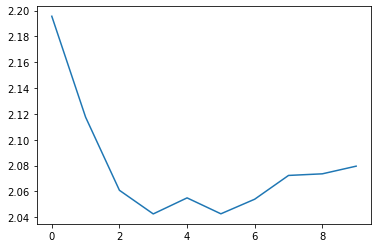

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(val_losses)

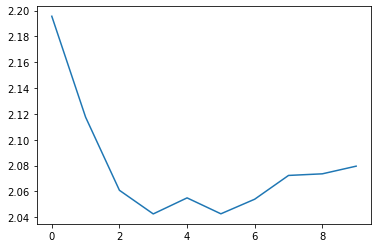

In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(val_losses)

In [ ]:
import pickle
import os

out_dir = f'./Models/1c_fine-tuned-bert-with-lex'
# out_dir = f'./Models/1b_fine-tuned-bert'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)


('./Models/1c_fine-tuned-bert-with-lex/tokenizer_config.json',
 './Models/1c_fine-tuned-bert-with-lex/special_tokens_map.json',
 './Models/1c_fine-tuned-bert-with-lex/vocab.txt',
 './Models/1c_fine-tuned-bert-with-lex/added_tokens.json')

## Run prediction

In [ ]:
out_dir = f'./Models/1c_fine-tuned-bert-with-lex'
# out_dir = f'./Models/1b_fine-tuned-bert'

model = CustomBertForSequenceClassification.from_pretrained(out_dir)
# model = BertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [70]:
batch_size = 32

test_data = TensorDataset(test_x, test_m, test_l)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m, mb_l) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_l = mb_l.to(device)
        if add_lexicon:
          output = model(mb_x, attention_mask=mb_m, lexicon_emb=mb_l)
        else:
          output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)


In [71]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()


In [72]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))
p, r, f1, sup = precision_recall_fscore_support(true_values, predicted_values, average="macro")
print("F1: %.3f" % f1)
print("P: %.3f" % p)
print("R: %.3f" % r)



Test Accuracy: 0.31011826544021026
                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.12      0.22      0.16        36
                       1.2 incitement and encouragement of harm       0.38      0.27      0.32        67
                                        2.1 descriptive attacks       0.30      0.41      0.35       106
                             2.2 aggressive and emotive attacks       0.29      0.46      0.36       118
        2.3 dehumanising attacks & overt sexual objectification       0.09      0.02      0.03        59
     3.1 casual use of gendered slurs, profanities, and insults       0.35      0.34      0.34       101
        3.2 immutable gender differences and gender stereotypes       0.39      0.61      0.48        83
                            3.3 backhanded gendered compliments       0.33      0.06      0.10        50
             3.4 co

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [ ]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)


Test Accuracy: 0.5058823529411764


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))
p, r, f1, sup = precision_recall_fscore_support(true_values, predicted_values, average="macro")
print("F1: %.3f" % f1)
print("P: %.3f" % p)
print("R: %.3f" % r)


                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00         5
                       1.2 incitement and encouragement of harm       0.68      0.59      0.63        22
                                        2.1 descriptive attacks       0.48      0.56      0.52        84
                             2.2 aggressive and emotive attacks       0.47      0.58      0.52        71
        2.3 dehumanising attacks & overt sexual objectification       0.20      0.04      0.07        23
     3.1 casual use of gendered slurs, profanities, and insults       0.65      0.72      0.68        58
        3.2 immutable gender differences and gender stereotypes       0.45      0.57      0.50        37
                            3.3 backhanded gendered compliments       0.00      0.00      0.00         5
             3.4 condescending explanations or unwelco

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 0  2  0  3  0  0  0  0  0  0  0]
 [ 0 13  2  6  0  1  0  0  0  0  0]
 [ 0  2 47 12  1  1 15  0  0  0  6]
 [ 0  1 10 41  1 15  2  0  0  0  1]
 [ 0  0  9  4  1  4  4  0  0  0  1]
 [ 0  0  5  9  1 42  1  0  0  0  0]
 [ 0  1 12  0  0  1 21  0  0  0  2]
 [ 0  0  1  1  1  0  1  0  0  0  1]
 [ 0  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  2  4  0  0  0  0  0  0  1]
 [ 0  0  9  5  0  1  3  0  0  0  7]]


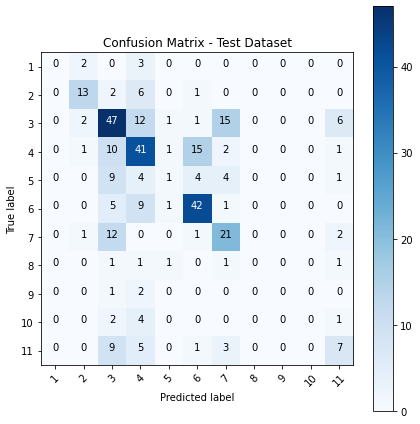

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=range(1, len(label_values)+1), title='Confusion Matrix - Test Dataset')
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)


## Create Submission

In [ ]:
ls ../Data

dev_task_a_entries.csv  starting_ki/             test_task_c_entries.csv
dev_task_b_entries.csv  test_task_a_entries.csv
dev_task_c_entries.csv  test_task_b_entries.csv


In [ ]:
dfdev = pd.read_csv("../Data/dev_task_b_entries.csv")
dftest = pd.read_csv("../Data/test_task_b_entries.csv")

In [ ]:
df = dftest
texts = df['text'].values

In [ ]:
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length') for text in texts]

In [ ]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

In [ ]:
lexcon_emb = []
for text in texts:
  words = word_tokenize(text)

  embs = []
  for w in words:
    e = []
    for label in lexicons:
      if w in lexicons[label]:
        e.append(1.0)
      else:
        e.append(0.0)
    embs.append(e)

  while len(embs) < 100:
    embs.append([0 for l in lexicons])
  lexcon_emb.append(embs)


In [ ]:
test_x = torch.tensor(text_ids);
test_m = torch.tensor(att_masks);
test_l = torch.tensor(lexcon_emb);

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
test_data = TensorDataset(test_x, test_m, test_l)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m, mb_l) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_l = mb_l.to(device)
        output = model(mb_x, attention_mask=mb_m, lexicon_emb=mb_l)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()

In [ ]:
def number_to_label(label):
  return label_map[label]

predicted_labels = list(map(number_to_label, predicted_values))

In [ ]:
df["label_pred"] = predicted_labels

In [ ]:
df[["rewire_id", "label_pred"]].to_csv(f"../Results/1c_lexbert_test.csv", index=False)

In [ ]:
ls -al ../Results

total 623825
-rw------- 1 root root     69142 Jan 18 15:54 1a_bert_dev.csv
-rw------- 1 root root    138088 Jan 18 15:54 1a_bert_test.csv
-rw------- 1 root root     69330 Jan 18 15:54 1a_twbert_dev.csv
-rw------- 1 root root    138552 Jan 18 15:54 1a_twbert_test.csv
-rw------- 1 root root     31643 Jan 21 21:51 1c_lexbert_dev.csv
-rw------- 1 root root     64197 Jan 21 21:51 1c_lexbert_test.csv
-rw------- 1 root root 593725821 Jan 19 19:55 PMI_gab.pickle
-rw------- 1 root root  44549335 Jan 19 19:53 shapley_values_gab.pickle
drwx------ 2 root root      4096 Jan 18 15:59 TaskB/
drwx------ 2 root root      4096 Jan 18 15:59 TaskC/
